<img src="../images/eedx_logo.png" width="500">

This notebook serves as an introduction and tutorial to Eco-Evo-Devox (EEDx), an artificial life platform designed to study the ecological and developmental roots of neural evolution. 

EEDx incorporates (i) ecological design/engineering and (ii) agents with neural ontogenies, i.e. nervous systems that grow and develop, all packed in a modular design.

In the first section, we will go through how agents are programmaticaly created. In a second part we will see how different types of environments with different ecological properties can be created. 


# Setup and Imports

In [1]:
%cd ..

import jax
import jax.random as jr
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML, display

/Users/erpl/Documents/eedx/ecoevodevox


# Creating Agents

First let's define some hyperparameters:
- `body_resolution`: bodies are discretized into `body_resolution * body_resolution` points (square lattice). These points are then used to compute overlap with environment cells. 
- `max_body_size`: maximum side length of agents bodies
- `min_body_size`: minimum ...

In [2]:
max_body_size = 10.0
min_body_size = 1.0
body_resolution = int(max_body_size)+1

Then, the complete agent model consists of:
- a neural model
- a sensory interface
- a motor interface

### Encoding and Neural model

The complete neural network is define by (i) an encoding model, called at initialization, defining how its structure is created  and (ii) a dynamical model specifying its update rule. Overall, the neural model, or policy, have the following structure:

```python
class NN(eqx.Module):
    def init(self, key)->State:
        """Initialize the network state"""
        return self.encoding_model(key)
    def __call__(self, inputs, state, key)->tuple[State,float,dict]:
        """return new state, energy spent and infos (can be empty dict)"""
        ...
```
All the model parameters can be integrated in the state via the encoding model or some can be specified within the policy model (`self`).

The encoding model should at least implement the `__call__` method.

```python 
class Encoding(eqx.Module):
    def __call__(self, key)->State:
        """generate initial state"""
        ...
```

Let's implement our encoding model. We'll use the RAND model (Regulation base Artificial NeuroDevlopment).

In [3]:
from src.devo import RAND

# we create a constructor function as we will need to create multiple instances of the same model
encoding_factory = partial(RAND, 
                           nb_neurons=1,            # number of initial neurons
                           max_neurons=64,          # maximum number of neurons
                           network_type="ctrnn",    # network type
                           sensory_genes=8,         # number of sensory genes
                           regulatory_genes=4)      # number of regulatory genes

encoding_model = encoding_factory(key=jr.key(61))
# let's inspect the model
encoding_model

RAND(
  W_in=f32[27,27],
  W_ex=f32[9,27],
  W_migr=f32[4,9],
  W_sign=f32[2,4],
  W_syn=f32[4,4],
  W_neur=Linear(
    weight=f32[3,1], bias=f32[3], in_features=1, out_features=3, use_bias=True
  ),
  bias=f32[27],
  tau=f32[27],
  O_syn=f32[1,4,4],
  nb_neurons=1,
  max_neurons=64,
  genes_shaper=<jax._src.util.HashablePartial object at 0x1137f5310>,
  total_genes=27,
  max_mitosis=10,
  mitotic_factor_threshold=10.0,
  apoptosis_factor_threshold=10.0,
  signalling_proteins=4,
  grn_model='continuous',
  autonomous_decay=True,
  dev_iters=400,
  network_type='ctrnn',
  expression_bounds=(0.0, 1.0),
  motor_activation_fn=<function RAND.<lambda>>,
  sensory_activation_fn=<function RAND.<lambda>>,
  gene_noise_scale=0.0,
  position_noise_scale=0.0
)

In [4]:
# # Let's test what this randmoly generated RAND does
# key_init, key_migr = jr.split(jr.key(1001), 2)
# state = encoding_model.init(key_init)
# final_state, data = encoding_model.do_migration(state, key_migr)
# xs = data["state"].X
# masks = data["state"].mask
# print("Number of neurons:", masks[-1].sum())
# for t in range(xs.shape[0]):
#     plt.scatter(*xs[t, masks[t]].T, color=plt.cm.winter(t/xs.shape[0]))
# plt.show()

Now let's define the dynamical model defining the dynamics of the network. We'll use Continuous Time Recurrent Neural Networks (CTRNNs). CTRNNs dynamics are defined by the following differential equation:
$$
\tau_i \frac{dv_i}{dt} = -v_i + \sum_j W_{ij} \sigma(v_j)
$$

In [5]:
from src.agents.nn import CTRNNNN, make_apply_init

# we create a constructor function as we will need to create multiple instances of the same model
def policy_factory(key):
    return CTRNNNN(encoding_model=encoding_factory(key=key))

# instantiate the policy
policy = policy_factory(jr.key(8))
# we then create init and apply function from this model
policy_apply, policy_init = make_apply_init(policy)


### Sensory Model

We'll use the spatially embedded sensory interface. Neurons must have positions `x` and sensory expressions `s`. 

Thhis interface works by using neurons spatial location and profiles to decide on their input. For instance if a neuron is located at the top right corner of the agent (pos=(1,1)) and this neuron is a snesory neuron (s=1), then it will receive as input the snesory values associated to the cell located right under it. As the agent body can span multiple differnt cells, neurons located at different positiosn will receive different inputs.

In [6]:
from src.agents.sensory import SpatiallyEmbeddedSensoryInterface

sensory_interface = SpatiallyEmbeddedSensoryInterface(body_resolution=body_resolution,
                                                      sensor_expression_threshold=0.1,
                                                      border_threshold=0.0,
                                                      sensor_energy_cost=0.1)

### Motor Model

Now, let's define how the neural state is decoded to produce actions. We'll use a Braitenberg vehicle interface. Neurons must have positions `x`amd motor expressions `m` defined through the encoding model.

Left and right wheels are placed at positions $(-1,0)$ and $(1,0)$ respectively. Neurons are motor if they are at a distance less than `max_distance_to_motor` to one of the motors and if their motor expression is greater than `motor_expression_threshold`.

In [7]:
from src.agents.motor import BraitenbergMotorInterface

motor_interface = BraitenbergMotorInterface(interface="se", max_distance_to_motor=0.5, max_wheel_speed=1.0, max_neuron_force=0.3, motor_expression_threshold=0.1)

### Create Complete Interface

Now let's put everything together to create the complete agent interface

In [8]:
from src.agents import AgentInterface, AgentConfig

agent_cfg = AgentConfig(max_age=1_000, init_energy=0.5, max_energy=10.0, 
                        basal_energy_loss=0.1, size_energy_cost=0.01, 
                        min_body_size=0.5, max_body_size=10.0, body_resolution=None,
                        time_below_threshold_to_die=20, time_above_threshold_to_reproduce=50, 
                        reproduction_energy_cost=1.0)

policy_prms_fctry = lambda key: eqx.filter(policy_factory(key), eqx.is_array)
agent_interface = AgentInterface(cfg=agent_cfg,
                                 policy_apply=policy_apply,
                                 policy_init=policy_init,
                                 policy_fctry=policy_prms_fctry,
                                 sensory_interface=sensory_interface,
                                 motor_interface=motor_interface)

In [9]:
# let's intitialize a single agent and see what it can do
from src.agents import Genotype
# first we need to specify its genotype
genotype = Genotype(policy_params=agent_interface.policy_fctry(jr.key(0)),
                    body_size=4.0,
                    chemical_emission_signature=jnp.zeros(()))
agent_state = agent_interface.init(genotype=genotype, position=jnp.zeros(2), heading=jnp.asarray(jnp.pi/2), id_=0, key=jr.key(2))

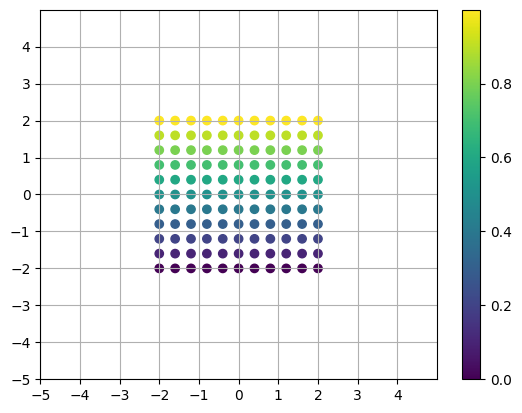

In [10]:
# let's look at how our agent body is diretized

body = agent_state.body.replace(heading=jnp.pi/2) #you can change the heading to rotate the agent
body_points = agent_interface.get_body_points(body)
deltas = agent_interface.body_discretization_deltas() 

plt.scatter(*body_points, c=deltas[1]+0.5) #color shows agent internal y-axis value (y=1.0 is front
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.xticks(np.arange(-5, 5))
plt.yticks(np.arange(-5, 5))
plt.grid(which="both")
plt.colorbar()
plt.show()

# Create world

We will now create the environment. The environment is specified by a set of food types and a set of chemical types. Each food type emits chemicals that diffuse in the environment. 

Let's start with a simple environment containing a single food type emitting a single chemical type

In [11]:
import jax.numpy as jnp
from src.eco import FoodType, ChemicalType

nb_food_types = 1
nb_chemical_types = 1

food_type = FoodType(growth_rate=jnp.full((nb_food_types,), 0.05 ), #probability to grow in an other cell
                     dmin=jnp.full((nb_food_types,), 1.0), # min distance of growth
                     dmax=jnp.full((nb_food_types,), 2.0), # max distance of growth
                     chemical_signature=jnp.full((nb_food_types, nb_chemical_types), 1.0), # chemical signature of the food (how much of each chemical is emitted)
                     energy_concentration=jnp.full((nb_food_types,), 1.0), # energy concentration of the food
                     spontaneous_grow_prob=jnp.full((nb_food_types,), 0.0), # probability to grow spontaneously
                     initial_density=jnp.full((nb_food_types,), 0.01)) # initial density of the food (prbability to be in any given cell)

Now let's define our chemical species. Chemicals are defined by their diffusion rates, i.e how far they spread (the width of a bell curve). If they are sparse emitters, meaning they emit particles not continuous fields. And at which rate they emit particles (only if sparse emitters).

In [12]:
chemical_type = ChemicalType(diffusion_rate=jnp.full((nb_chemical_types,), 10.0), 
                             is_sparse=jnp.full((nb_chemical_types,), False), 
                             emission_rate=jnp.full((nb_chemical_types,), 0.0))

In [13]:
from src.eco import GridWorld, GridworldConfig

world_cfg = GridworldConfig(size=(128,128))

world = GridWorld(cfg=world_cfg, chemical_types=chemical_type, food_types=food_type)

Now let's simulate our world !

first we initialize it

In [14]:
env_state = world.init(key=jr.key(1))

Let's first look at how ood emits chemicals 

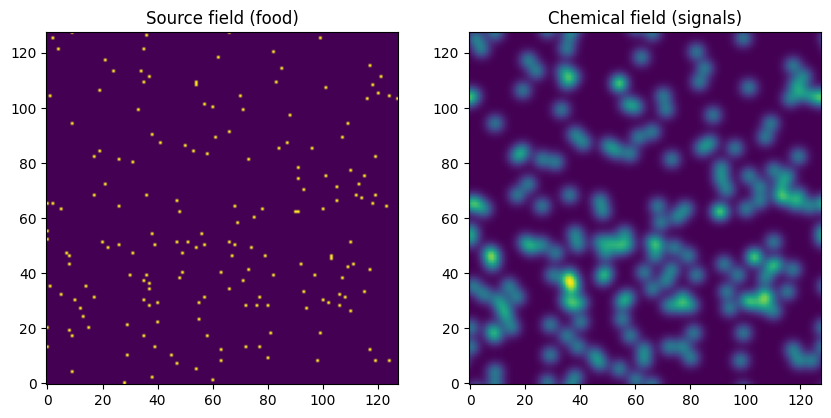

In [15]:
chemical_fields = world.compute_chemical_fields(env_state, key=jr.key(1))
fig, axs = plt.subplots(chemical_fields.shape[0], 2, figsize=(10, 5), squeeze=False)
for ax, source, chem in zip(axs, env_state.food, chemical_fields):
    ax[0].imshow(source.T, origin="lower")
    ax[1].imshow(chem.T, origin="lower")
axs[0,0].set_title("Source field (food)")
axs[0,1].set_title("Chemical field (signals)")
plt.show()

Now, let's see different types of chemical types:

In [28]:
ft1 = FoodType(growth_rate=jnp.full((1,), 0.0 ), #not growing
               dmin=jnp.full((1,), 1.0),
               dmax=jnp.full((1,), 2.0),
               chemical_signature=jnp.ones((1, 3)), # emit all 3 types of chemicals
               energy_concentration=jnp.full((1,), 1.0),
               spontaneous_grow_prob=jnp.full((1,), 0.0),
               initial_density=jnp.full((1,), 0.01))


food_types = ft1

ct1 = ChemicalType(diffusion_rate=jnp.full((1,), 10.0), 
                   is_sparse=jnp.full((1,), False), 
                   emission_rate=jnp.full((1,), 0.0))

ct2 = ChemicalType(diffusion_rate=jnp.full((1,), 100.0), # Higher diffusion rate
                   is_sparse=jnp.full((1,), False), 
                   emission_rate=jnp.full((1,), 1.0))

ct3 = ChemicalType(diffusion_rate=jnp.full((1,), 5.0), 
                   is_sparse=jnp.full((1,), True),  # sparse emission
                   emission_rate=jnp.full((1,), 0.05))

chemical_types = jax.tree.map(lambda a, b, c: jnp.concatenate([a, b, c], axis=0), ct1, ct2, ct3)

In [29]:
# we can instantiate a wold with the same agent interface and mutation function than before
world = GridWorld(world_cfg, food_types=food_types, chemical_types=chemical_types)
env_state = world.init(key=jr.key(8))

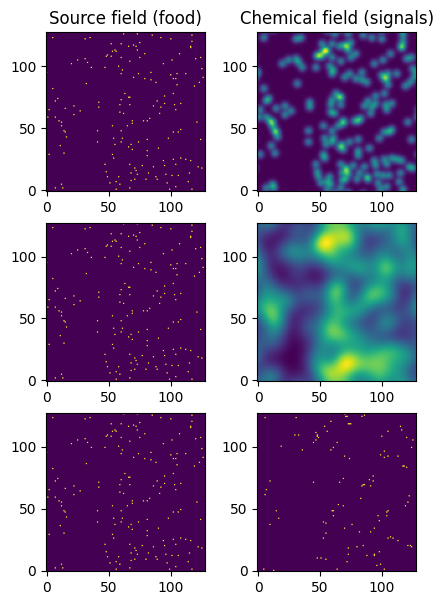

In [30]:
chemical_fields = world.compute_chemical_fields(env_state, key=jr.key(1))
fig, axs = plt.subplots(chemical_fields.shape[0], 2, figsize=(5, 7), squeeze=False)
for ax, chem in zip(axs, chemical_fields):
    ax[0].imshow(env_state.food[0].T, origin="lower")
    ax[1].imshow(chem.T, origin="lower")
axs[0,0].set_title("Source field (food)")
axs[0,1].set_title("Chemical field (signals)")
plt.show()

As you can see, the last filed is binary. It is because we have set is_sparse to True changing the diffusiion mode from continuous to event-based. This is simply done by treating the continuous concentration field as a probability field defining the probab that a chemical will be present in the each cell.

We can see that these chemicals provide very different signal landscapes requiring different strategies to navigate!

The "sparse" chemical is intermittent and stochastic, let's see how it evolves through time 

In [31]:
chemical_fields = jax.vmap(lambda s, k: world.compute_chemical_fields(s, key=k), in_axes=(None,0))(env_state, jr.split(jr.key(1), 500)) 

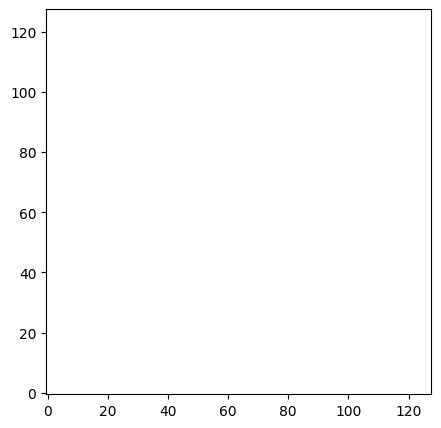

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cam = Camera(fig)

for field in chemical_fields:
    ax.imshow(field[-1].T, origin="lower")
    cam.snap()

anim = cam.animate(interval=50)
display(HTML(anim.to_html5_video()))

If we look at the frequency of signals in each cell we recover the expected signal

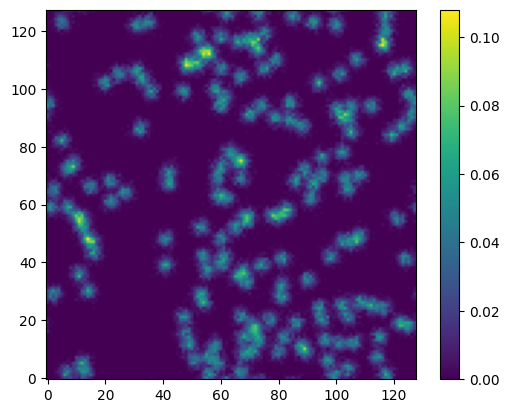

In [33]:
plt.imshow(chemical_fields.mean(0)[-1].T, origin="lower")
plt.colorbar()
plt.show()

# Sensors, Neurons and Motors

Let's now look at how our agents perceive the world

position: [32. 32.] 
heading: 1.5707963267948966


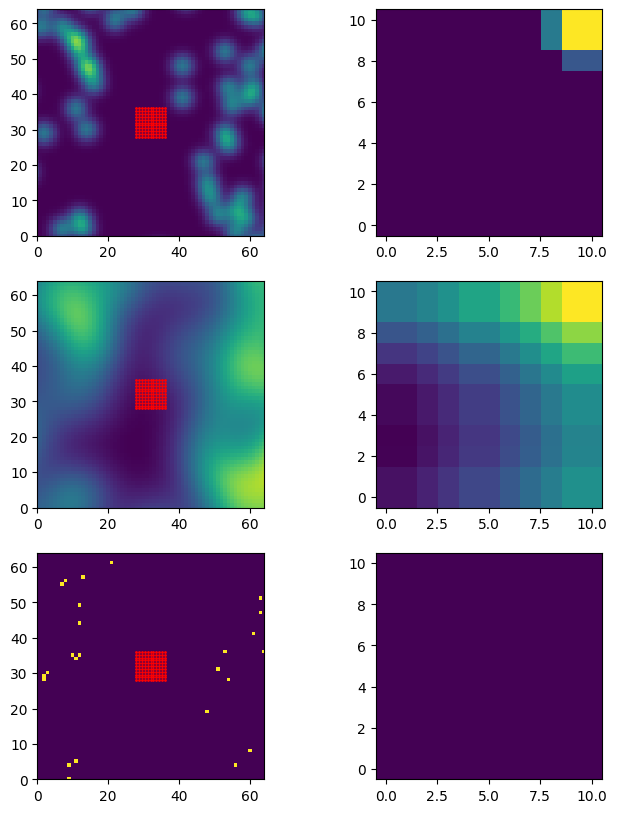

In [46]:
chemical_fields = world.compute_chemical_fields(env_state, key=jr.key(101))
body = body.replace(pos=jnp.ones(2)*32, size=8.0, heading=jnp.pi/2) #chage values here to change perception

print(f"position: {body.pos} \nheading: {body.heading}")
# let's now look at how this body is discretized
points = agent_interface.get_body_points(body)

fig, ax = plt.subplots(3, 2, figsize=(8,10))
obs = world.vision_fn(chemical_fields, points)
for i, (cf, o) in enumerate(zip(chemical_fields, obs)): 
    ax[i, 0].scatter(*points, s=1., color="r")
    ax[i, 0].set_xlim(0, 64)
    ax[i, 0].set_ylim(0, 64)
    ax[i, 0].imshow(cf.T, origin="lower")
    ax[i, 1].imshow(o.T, origin="lower")
plt.show()

# Running simulations

A simulator class is integrated to EEDx to help mange simulations, logging and checkpointing.

In [23]:
from src.simulation import Simulator, SimulationConfig
from src.evo import GeneralizedMutation

sim_cfg = SimulationConfig(max_agents=64, #maximum number of agents in environment
                           init_agents=8, #umber of agents at initialization 
                           birth_pool_size=4) # max number of births per steps

mutation_model = GeneralizedMutation(0.04, 1.0, agent_state.genotype)            

sim = Simulator(cfg=sim_cfg,
                world=world,
                agent_interface=agent_interface,
                mutation_fn=mutation_model)

Now we have our simulator, let's try it !


    Starting interactive simulation !

    Run name: no logging
    
    Commands:
    i, init, initialize: initialize simulation
    s, sim, simulate [steps]: simulate the world for a given number of steps (default: 1)
    r, render: render the world
    q: quit the simulation
    h, help: show this help message
    
Simulating 1 steps...


/Users/erpl/Documents/eedx/ecoevodevox/.venv/lib/python3.13/site-packages/jax/_src/ops/scatter.py:104: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=float16 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


invalid cmd, use q to exit


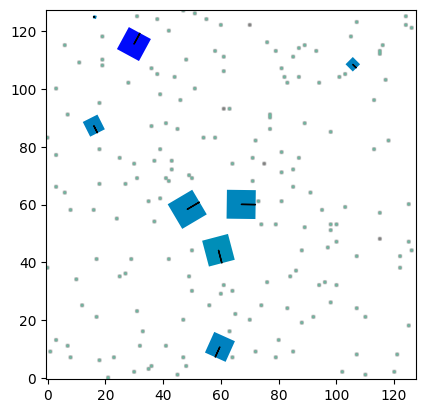

Simulating 10 steps...


/Users/erpl/Documents/eedx/ecoevodevox/.venv/lib/python3.13/site-packages/jax/_src/ops/scatter.py:104: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=float16 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


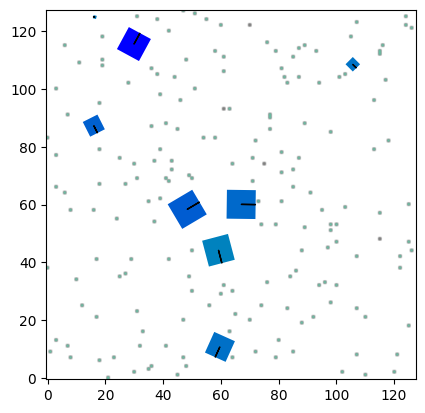

In [26]:
from src.simulation import run_interactive

sim_state = run_interactive(sim, key=jr.key(1))